In [1]:
import tensorflow as tf

from distill.common.hparams import TransformerHparam, LSTMHparam
import os

from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicIdentityBinary40, \
  AlgorithmicAdditionDecimal40, AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSameLength, ArithmaticSimple, ArithmaticSimpleCurriculumLength,\
ArithmaticSimpleSameLength10, ArithmaticSimpleSameLength10Depth6, ArithmaticSimpleSameLength10Depth2, ArithmaticSimpleSameLength10Depth4
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_trec6 import CharTrec6, Trec6
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.distill_pipelines import Seq2SeqDistiller
from distill.pipelines.seq2seq import Seq2SeqTrainer

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [2]:
tf.app.flags.DEFINE_string("exp_name", "distill", "")
tf.app.flags.DEFINE_string("task_name", "identity_binary", "")
tf.app.flags.DEFINE_string("log_dir", "logs", "")
tf.app.flags.DEFINE_string("data_dir", "data", "")

tf.app.flags.DEFINE_string("save_dir", None, "")

tf.app.flags.DEFINE_string("model_type", "lstm2transformer", "")
tf.app.flags.DEFINE_string("teacher_model", "lstm", "")
tf.app.flags.DEFINE_string("student_model", "enc_utransformer", "")

tf.app.flags.DEFINE_boolean("train_teacher", True, "")
tf.app.flags.DEFINE_boolean("train_student", True, "")
tf.app.flags.DEFINE_boolean("distill_rep", False, "")
tf.app.flags.DEFINE_boolean("distill_logit", True, "")

tf.app.flags.DEFINE_boolean("pretrain_teacher", True, "")
tf.app.flags.DEFINE_integer("teacher_pretraining_iters", 100, "")
tf.app.flags.DEFINE_string("rep_loss_mode", 'dot_product', "representation loss type (squared,softmax_cross_ent,sigmoid_cross_ent")

tf.app.flags.DEFINE_string("model", "enc_utransformer", "transformer | utransformer | lstm | bilstm")
tf.app.flags.DEFINE_string("teacher_encoder_attention_dir", "top_down", "top_down | bottom_up")
tf.app.flags.DEFINE_string("student_encoder_attention_dir", "top_down", "top_down | bottom_up")


tf.app.flags.DEFINE_integer("teacher_hidden_dim", 256, "")
tf.app.flags.DEFINE_integer("teacher_encoder_depth", 1, "")
tf.app.flags.DEFINE_integer("teacher_decoder_depth", 1, "")
tf.app.flags.DEFINE_integer("student_hidden_dim", 128, "")
tf.app.flags.DEFINE_integer("student_encoder_depth", 4, "")
tf.app.flags.DEFINE_integer("student_decoder_depth", 1, "")

tf.app.flags.DEFINE_integer("input_dim", None, "")
tf.app.flags.DEFINE_integer("output_dim", 1, "")
tf.app.flags.DEFINE_integer("number_of_heads", 4, "")
tf.app.flags.DEFINE_integer("ff_filter_size", 512, "")
tf.app.flags.DEFINE_float("initializer_gain", 1.0, "")
tf.app.flags.DEFINE_float("teacher_label_smoothing", 0.0001, "")
tf.app.flags.DEFINE_float("student_label_smoothing", 0.0001, "")

tf.app.flags.DEFINE_boolean('teacher_train_embeddings', True, " False | True")
tf.app.flags.DEFINE_boolean('student_train_embeddings', True, " False | True")

tf.app.flags.DEFINE_string('teacher_sent_rep_mode', "all", "none | final | all")
tf.app.flags.DEFINE_string('student_sent_rep_mode', "all", "none | final | all")

tf.app.flags.DEFINE_string('teacher_attention_mechanism', None, 'attention_mechanism')
tf.app.flags.DEFINE_string('student_attention_mechanism', None, 'attention_mechanism')


tf.app.flags.DEFINE_float("teacher_input_dropout_keep_prob", 0.8, "")
tf.app.flags.DEFINE_float("teacher_hidden_dropout_keep_prob", 0.9, "")
tf.app.flags.DEFINE_float("student_input_dropout_keep_prob", 0.75, "")
tf.app.flags.DEFINE_float("student_hidden_dropout_keep_prob", 0.5, "")


tf.app.flags.DEFINE_float("teacher_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("student_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("distill_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("data_weight", 0.00, "")
tf.app.flags.DEFINE_float("distill_logits_weight", 1.00, "")

tf.app.flags.DEFINE_float("distill_temp", 1, "")
tf.app.flags.DEFINE_float("teacher_temp", 1, "")
tf.app.flags.DEFINE_float("student_temp", 1, "")
tf.app.flags.DEFINE_boolean("learn_to_teach", False, "")



tf.app.flags.DEFINE_boolean("decay_learning_rate", True, "True | False")
tf.app.flags.DEFINE_float("l2_rate", 0.0001, "")


tf.app.flags.DEFINE_integer("batch_size", 32, "")
tf.app.flags.DEFINE_integer("training_iterations", 300000, "")

tf.app.flags.DEFINE_integer("vocab_size", 3, "")
tf.app.flags.DEFINE_integer("embedding_dim", 128, "embeddings dim")

tf.app.flags.DEFINE_string("data_path", "../data", "data path")
tf.app.flags.DEFINE_string("f","","kernel")
hparams = tf.app.flags.FLAGS

In [3]:
Models = {"lstm": LSTMSeq2Seq,
        "bilstm": BidiLSTMSeq2Seq,
        "transformer": Transformer,
        "utransformer": UniversalTransformer,
        "enc_transformer": EncodingTransformer,
        "enc_utransformer": EncodingUniversalTransformer}


tasks = {'identity': AlgorithmicIdentityDecimal40(os.path.join(hparams.data_dir,'alg')),
       'identity_binary': AlgorithmicIdentityBinary40(os.path.join(hparams.data_dir,'alg')),
       'addition': AlgorithmicAdditionDecimal40(os.path.join(hparams.data_dir,'alg')),
       'multiplication': AlgorithmicMultiplicationDecimal40(os.path.join(hparams.data_dir,'alg')),
       'sort': AlgorithmicSortProblem(os.path.join(hparams.data_dir,'alg')),
       'reverse': AlgorithmicReverseProblem(os.path.join(hparams.data_dir,'alg')),
       'arithmatic': Arithmatic(os.path.join(hparams.data_dir,'arithmatic')),
       'arithmatic_simple': ArithmaticSimple(os.path.join(hparams.data_dir,'arithmatic_simple')),
       'arithmatic_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_curriculum_length': ArithmaticSimpleCurriculumLength(os.path.join(hparams.data_dir,'arithmatic_simple_curriculum_length')),
       'arithmatic_simple_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_samelength10': ArithmaticSimpleSameLength10(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10')),
       'arithmatic_simple_samelength10_depth6': ArithmaticSimpleSameLength10Depth6(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth6')),
       'arithmatic_simple_samelength10_depth4': ArithmaticSimpleSameLength10Depth4(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth4')),
       'arithmatic_simple_samelength10_depth2': ArithmaticSimpleSameLength10Depth2(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth2')),
       }


In [4]:
hparams.task_name = 'arithmatic_simple_samelength10_depth2'
hparams.vocab_size = tasks[hparams.task_name].vocab_length
hparams.output_dim = len(tasks[hparams.task_name].target_vocab)

PARAM_TYPES = {"lstm": LSTMHparam,
        "bilstm": LSTMHparam,
        "transformer": TransformerHparam,
        "utransformer": TransformerHparam,
        "enc_transformer": TransformerHparam,
        "enc_utransformer": TransformerHparam}

teacher_params = PARAM_TYPES[hparams.teacher_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.teacher_hidden_dim,
                                                  encoder_depth=hparams.teacher_encoder_depth,
                                                  decoder_depth=hparams.teacher_decoder_depth,
                                                  number_of_heads=2,
                                                  ff_filter_size=512,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.teacher_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.teacher_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.teacher_label_smoothing,
                                                  encoder_self_attention_dir=hparams.teacher_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.teacher_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.teacher_sent_rep_mode,
                                                  embedding_dim=hparams.teacher_hidden_dim,
                                                  learning_rate=hparams.teacher_learning_rate
                                                  )

student_params = PARAM_TYPES[hparams.student_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.student_hidden_dim,
                                                  encoder_depth=hparams.student_encoder_depth,
                                                  decoder_depth=hparams.student_decoder_depth,
                                                  number_of_heads=2,
                                                  ff_filter_size=512,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.student_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.student_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.student_label_smoothing,
                                                  encoder_self_attention_dir=hparams.student_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.student_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.student_sent_rep_mode,
                                                  embedding_dim=hparams.student_hidden_dim,
                                                  learning_rate=hparams.student_learning_rate
                                                  )

In [5]:
print(hparams.student_model)
student_model = Models[hparams.student_model](student_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.student_model+"_student")

enc_utransformer


In [6]:
dataset = tf.data.TFRecordDataset("../"+student_model.task.get_tfrecord_path(mode="train"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
train_iterator = dataset.make_one_shot_iterator()

dataset = tf.data.TFRecordDataset("../"+student_model.task.get_tfrecord_path(mode="dev"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
dev_iterator = dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()

student_model.create_vars(reuse=False)
weights_dic = {}
train_output_dic = student_model.apply(teacher_train_examples, target_length=student_model.task.target_length, is_train=True, dic_to_save_weights=weights_dic)

INFO:tensorflow:encoder inputs:
INFO:tensorflow:tf.Tensor(
[[[-0.         -0.13447715 -2.9462345  ...  1.3838401   0.35688075
    0.3128222 ]
  [-1.5214005   0.         -0.         ...  1.8012882  -0.11338854
    0.9434073 ]
  [ 1.6049699   3.8711987   2.2582848  ...  0.21802671  0.27212515
    4.5632143 ]
  ...
  [ 0.          0.10803419  0.48360345 ...  0.          1.3333101
    0.        ]
  [ 1.3155035   1.0807419   0.         ...  1.333301    0.
    1.3333153 ]
  [ 0.          1.2956555   1.276384   ...  0.          1.3333082
    0.        ]]

 [[-0.          0.         -1.3124306  ...  1.7037934   0.09017698
    2.2058437 ]
  [ 1.5145346   3.5682201   1.8343974  ...  0.2180268   0.
    4.5632143 ]
  [-0.5389553   0.         -1.616939   ...  1.38384     0.35688075
    0.        ]
  ...
  [ 0.89363885  0.10803419  0.48360345 ...  1.3333021   1.3333101
    1.333316  ]
  [ 1.3155035   1.0807419   0.         ...  1.333301    1.3333092
    1.3333153 ]
  [ 0.52790016  1.2956555   1.2763

In [19]:
hparams.save_dir = '../logs/arithmatic_simple_samelength10_depth2/'+ \
'dot_product_lstm_to_enc_utransformer_std_depth4_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__logits3_replicate_2'
checkpoint = tf.train.latest_checkpoint(hparams.save_dir)
                                        

In [20]:
with tfe.restore_variables_on_create(checkpoint):
    outputs = train_output_dic = student_model.apply(teacher_train_examples, target_length=student_model.task.target_length, is_train=True)

INFO:tensorflow:encoder inputs:
INFO:tensorflow:tf.Tensor(
[[[-0.         -0.13447715 -2.9462345  ...  1.3838401   0.35688075
    0.3128222 ]
  [-1.5214005   0.         -0.28144327 ...  0.         -0.11338854
    0.        ]
  [ 1.6049699   3.8711987   2.2582848  ...  0.21802671  0.
    4.5632143 ]
  ...
  [ 0.89363885  0.10803419  0.48360345 ...  1.3333021   1.3333101
    1.333316  ]
  [ 1.3155035   0.          1.1987605  ...  0.          1.3333092
    1.3333153 ]
  [ 0.52790016  1.2956555   1.276384   ...  1.3332998   0.
    1.3333145 ]]

 [[-1.2838075   1.178838   -0.         ...  1.7037934   0.09017698
    2.2058437 ]
  [ 1.5145346   3.5682201   1.8343974  ...  0.2180268   0.27212515
    4.5632143 ]
  [-0.          1.1824197  -1.616939   ...  1.38384     0.
    0.3128222 ]
  ...
  [ 0.89363885  0.          0.48360345 ...  1.3333021   1.3333101
    1.333316  ]
  [ 1.3155035   1.0807419   1.1987605  ...  1.333301    1.3333092
    1.3333153 ]
  [ 0.          0.          0.         ...

In [63]:
outputs.keys()

dict_keys(['logits', 'outputs', 'predictions', 'targets', 'trainable_vars'])

In [64]:
outputs['predictions'].numpy() - outputs['targets'].numpy()

array([[10],
       [ 0],
       [ 0],
       [-2],
       [ 7],
       [-4],
       [-6],
       [ 2],
       [-4],
       [ 9],
       [ 3],
       [ 9],
       [ 6],
       [ 6],
       [-1],
       [ 8],
       [-4],
       [ 2],
       [ 4],
       [10],
       [-1],
       [ 7],
       [ 2],
       [-5],
       [ 1],
       [10],
       [12],
       [-6],
       [ 4],
       [-6],
       [-2],
       [ 3]])

In [65]:
student_model.apply(teacher_train_examples, target_length=student_model.task.target_length, is_train=True)

{'logits': <tf.Tensor: id=11798, shape=(32, 1, 16), dtype=float32, numpy=
 array([[[ 1.21197507e-01, -2.48615593e-01,  8.03741068e-02,
          -4.02216196e-01,  3.55105430e-01,  4.44529623e-01,
           6.15305424e-01, -2.18068153e-01,  6.84876293e-02,
           2.80209094e-01, -2.63566762e-01,  1.20573729e-01,
          -6.13164231e-02,  2.00085506e-01,  4.90574278e-02,
           1.51378155e-01]],
 
        [[-8.11146349e-02, -1.05492733e-01,  6.12098932e-01,
          -4.21342775e-02, -9.51848626e-02, -1.22801572e-01,
           2.00182110e-01, -1.53522551e-01, -4.13433492e-01,
          -2.57523388e-01, -3.56329709e-01, -1.00950375e-01,
          -5.48861176e-03,  6.82162642e-02,  4.30167675e-01,
           5.08807674e-02]],
 
        [[ 1.37123987e-02, -4.96634990e-01, -5.92177033e-01,
          -2.27639675e-01,  1.06675074e-01,  4.87197399e-01,
           1.02018610e-01, -1.53690755e-01,  3.48125398e-02,
           3.44635099e-01, -2.29998246e-01, -3.48908126e-01,
          

In [66]:
inputs, targets, _, _ = teacher_train_examples

In [67]:
teacher_train_examples[3]

<tf.Tensor: id=6916, shape=(32,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>

In [68]:
student_model.task.decode(inputs[0])
student_model.task.decode(inputs[0])

['(',
 '4',
 '-',
 '4',
 ')',
 '+',
 '5',
 '+',
 '4',
 '-',
 '9',
 '+',
 '(',
 '9',
 '-',
 '5',
 '+',
 '3',
 '-',
 '(',
 '7',
 '-',
 '3',
 ')',
 '-',
 '1',
 ')',
 '+',
 '2',
 '+',
 '4',
 '+',
 '2',
 '-',
 '1',
 '-',
 '(',
 '6',
 '-',
 '5',
 ')',
 '-',
 '3',
 '-',
 '3',
 '<eos>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [82]:
example_str = '1 + 1'
example_input = example_str.split()
target = str(eval(example_str))
encoded_example = tf.convert_to_tensor([student_model.task.encode(example_input)])
encoded_target = tf.convert_to_tensor([student_model.task.encode(target)])

print(example_input)
example = (encoded_example, encoded_target, tf.convert_to_tensor([len(example_input)]), tf.convert_to_tensor([1]))

weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    outputs = train_output_dic = student_model.apply(example, \
                                                     target_length=student_model.task.target_length, is_train=True,dic_to_save_weights=weights_dic)

['1', '+', '1']
INFO:tensorflow:encoder inputs:
INFO:tensorflow:tf.Tensor(
[[[-1.076679   -0.8234668  -0.999155   -0.5190887  -1.2478405
   -0.6354905  -0.85301846  0.42287478  1.2997593  -0.
   -0.         -1.0725878   3.0748107   0.8822734  -1.2681135
    0.         -2.2362525   0.         -2.2287598  -0.93882656
    1.0681638  -0.933002   -0.          0.49940276 -0.
    0.8653574  -0.83421874 -0.04384374  0.83935696  0.24130096
    0.35470366 -0.5338362   0.8053939  -1.1502548   1.482339
    0.5382969   0.08326152 -0.6527205  -0.19553377 -2.0127473
    3.054743    2.2742422  -2.476779   -0.         -0.23862565
   -0.9891114   0.35283998  0.          0.591042   -0.
    2.133826   -0.          0.         -0.6488447  -0.
    0.716685    0.80807287 -0.         -1.0537748  -1.7756153
    0.36490533 -1.3769717  -0.78347737  0.83467644  1.9381461
   -0.          4.15736     2.9712746  -0.43455616  0.
    0.          5.2260146   0.52445674 -0.09708563  1.5969454
   -1.5035807   1.2863065  -

1 + 1
['7']
(2, 3, 3)


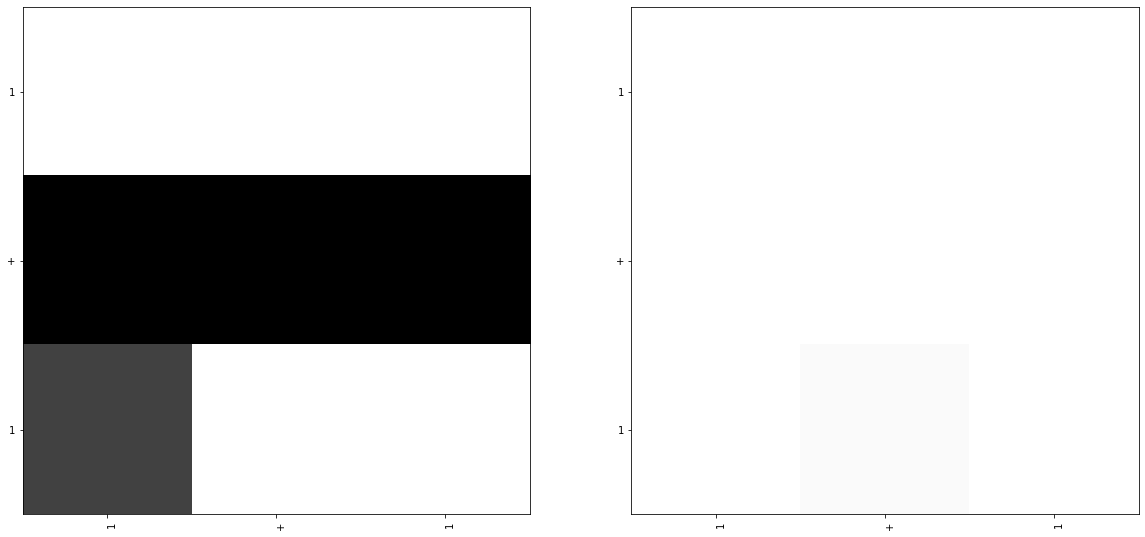

In [83]:
index=0
print(' '.join(student_model.task.decode(example[0][0])))
print(student_model.task.decode([np.argmax(outputs['logits'][0][0])]))
attention_mat = weights_dic['enc_utransformer_student/encode/UniversalTransformerEncoder/attention/_0_attention_logits'][index].numpy()
print(attention_mat.shape)
num_heads = 2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline  

plt.figure(figsize=(20,10))

for head in np.arange(1,num_heads+1):
    axes[head] = plt.subplot(1,2,head)
    im = axes[head].imshow(attention_mat[head-1],cmap=plt.cm.binary, vmin=0, vmax=1)
    axes[head].set_xticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_xticklabels(student_model.task.decode(example[0][index]))
    axes[head].set_yticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_yticklabels(student_model.task.decode(example[0][index]))
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[head].get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
plt.show()

In [79]:
np.argmax(outputs['logits'][0][0])

4

In [22]:
weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    outputs = train_output_dic = student_model.apply(teacher_train_examples, \
                                                     target_length=student_model.task.target_length, is_train=True,dic_to_save_weights=weights_dic)

INFO:tensorflow:encoder inputs:
INFO:tensorflow:tf.Tensor(
[[[-0.         -0.         -2.9462345  ...  1.3838401   0.35688075
    0.        ]
  [-1.5214005   0.61313015 -0.         ...  0.         -0.11338854
    0.9434073 ]
  [ 1.6049699   3.8711987   2.2582848  ...  0.21802671  0.27212515
    4.5632143 ]
  ...
  [ 0.89363885  0.10803419  0.48360345 ...  1.3333021   1.3333101
    1.333316  ]
  [ 0.          0.          1.1987605  ...  1.333301    1.3333092
    1.3333153 ]
  [ 0.52790016  0.          1.276384   ...  0.          1.3333082
    1.3333145 ]]

 [[-1.2838075   1.178838   -1.3124306  ...  1.7037934   0.09017698
    0.        ]
  [ 1.5145346   0.          1.8343974  ...  0.2180268   0.27212515
    4.5632143 ]
  [-0.5389553   1.1824197  -0.         ...  1.38384     0.35688075
    0.        ]
  ...
  [ 0.          0.10803419  0.         ...  1.3333021   1.3333101
    1.333316  ]
  [ 0.          1.0807419   1.1987605  ...  1.333301    1.3333092
    1.3333153 ]
  [ 0.52790016  1.2

5 - 2 + ( 4 + 3 ) - ( 3 + ( 1 + 2 ) ) + 7 + 1 - ( 7 - ( 8 - 5 ) ) - 3 - 2 + ( 5 - 4 ) + ( 4 - ( 3 + 1 ) ) <eos>
(2, 54, 54)


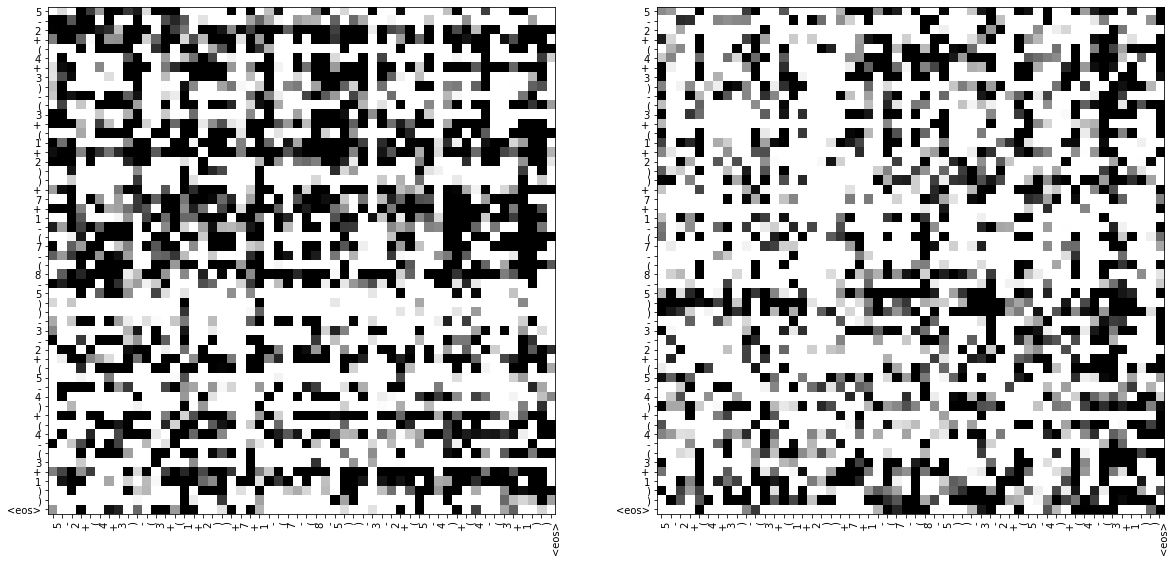

In [56]:
#@title Encoder attention at different layers

index = 10
print(' '.join(student_model.task.decode(teacher_train_examples[0][index])))
attention_mat = weights_dic['enc_utransformer_student/encode/UniversalTransformerEncoder/attention/_0_attention_logits'][index].numpy()
print(attention_mat.shape)
num_heads = 2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline  

plt.figure(figsize=(20,10))

for head in np.arange(1,num_heads+1):
    axes[head] = plt.subplot(1,2,head)
    im = axes[head].imshow(attention_mat[head-1],cmap=plt.cm.binary, vmin=0, vmax=1)
    axes[head].set_xticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_xticklabels(student_model.task.decode(teacher_train_examples[0][index]))
    axes[head].set_yticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_yticklabels(student_model.task.decode(teacher_train_examples[0][index]))
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[head].get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
plt.show()

5 - 2 + ( 4 + 3 ) - ( 3 + ( 1 + 2 ) ) + 7 + 1 - ( 7 - ( 8 - 5 ) ) - 3 - 2 + ( 5 - 4 ) + ( 4 - ( 3 + 1 ) ) <eos>
(2, 54, 54)


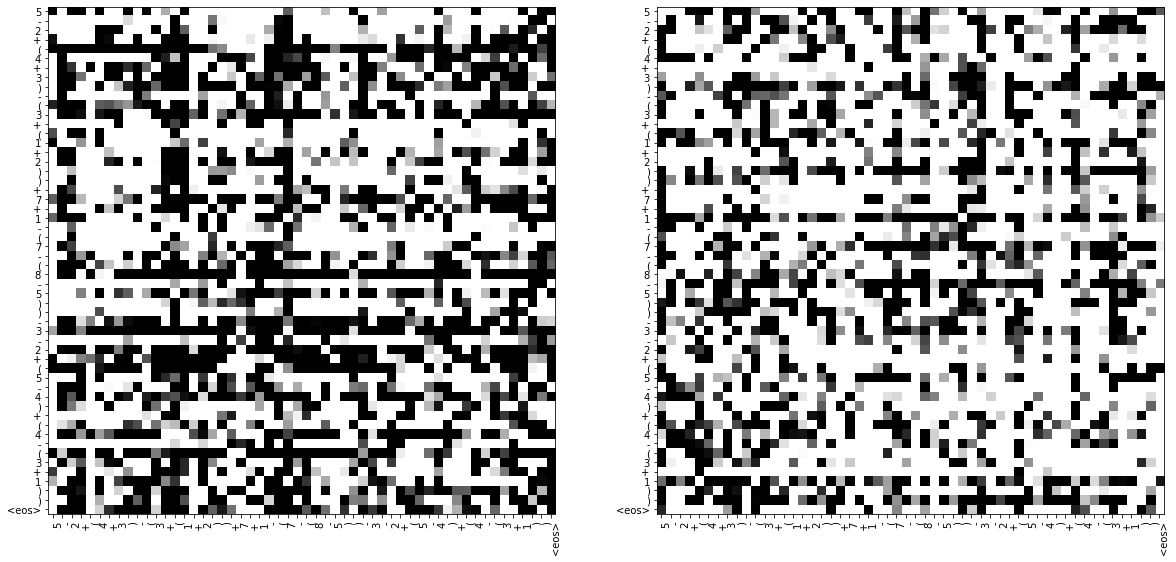

In [50]:
#@title Encoder attention at different layers

index = 10
print(' '.join(student_model.task.decode(teacher_train_examples[0][index])))
attention_mat = weights_dic['enc_utransformer_student/encode/UniversalTransformerEncoder/attention/_1_attention_logits'][index].numpy()
print(attention_mat.shape)
num_heads = 2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline  

plt.figure(figsize=(20,10))

for head in np.arange(1,num_heads+1):
    axes[head] = plt.subplot(1,2,head)
    im = axes[head].imshow(attention_mat[head-1],cmap=plt.cm.binary, vmin=0, vmax=1)
    axes[head].set_xticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_xticklabels(student_model.task.decode(teacher_train_examples[0][index]))
    axes[head].set_yticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_yticklabels(student_model.task.decode(teacher_train_examples[0][index]))
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[head].get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
plt.show()

5 - 2 + ( 4 + 3 ) - ( 3 + ( 1 + 2 ) ) + 7 + 1 - ( 7 - ( 8 - 5 ) ) - 3 - 2 + ( 5 - 4 ) + ( 4 - ( 3 + 1 ) ) <eos>
(2, 54, 54)


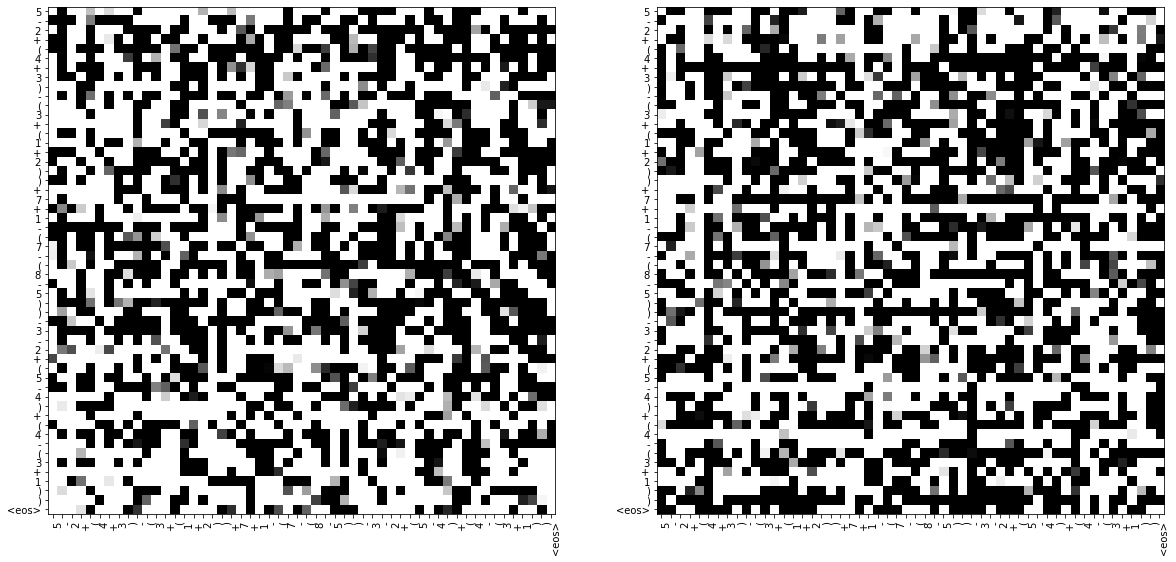

In [51]:
#@title Encoder attention at different layers

index = 10
print(' '.join(student_model.task.decode(teacher_train_examples[0][index])))
attention_mat = weights_dic['enc_utransformer_student/encode/UniversalTransformerEncoder/attention/_3_attention_logits'][index].numpy()
print(attention_mat.shape)
num_heads = 2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline  

plt.figure(figsize=(20,10))

for head in np.arange(1,num_heads+1):
    axes[head] = plt.subplot(1,2,head)
    im = axes[head].imshow(attention_mat[head-1],cmap=plt.cm.binary, vmin=0, vmax=1)
    axes[head].set_xticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_xticklabels(student_model.task.decode(teacher_train_examples[0][index]))
    axes[head].set_yticks(np.arange(attention_mat[head-1].shape[1]))
    axes[head].set_yticklabels(student_model.task.decode(teacher_train_examples[0][index]))
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[head].get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
plt.show()

In [84]:
with tfe.restore_variables_on_create(checkpoint):
    emb_w = student_model.input_embedding_layer.shared_weights

In [85]:
emb_w.numpy().shape

(16, 128)

In [86]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import manifold


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(emb_w.numpy())
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_emb = tsne.fit_transform(emb_w.numpy())

In [87]:
principalComponents

array([[ 0.10536157, -0.37004325],
       [-0.6418421 , -0.22325408],
       [-0.30643505,  0.2864765 ],
       [-0.04052083,  0.73840463],
       [ 0.23627988,  0.13373758],
       [-0.15915693,  0.14816792],
       [ 0.6571687 , -0.3242914 ],
       [ 0.31917593,  0.03355191],
       [ 0.01453368, -0.04067526],
       [-0.02579935, -0.14920075],
       [ 0.02350289, -0.5429554 ],
       [-0.09463326,  0.12813078],
       [-0.34032184, -0.34150213],
       [ 0.5718193 ,  0.18007077],
       [-0.38609684,  0.02817542],
       [ 0.06696419,  0.31520656]], dtype=float32)

In [88]:
student_model.task.id2word

['<pad>',
 '<eos>',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '(',
 ')',
 '+',
 '-']

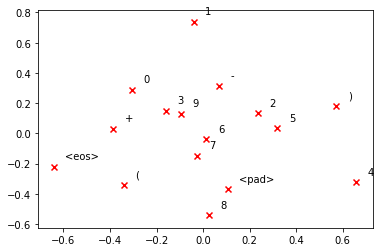

In [89]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+.05, y+.05, word, fontsize=10)
    plt.show()

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

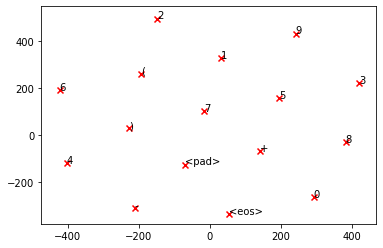

In [90]:
M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)